In [1]:
import json
import torch
from pathlib import Path
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from detr_modified.models.detr import PostProcess
from detr_modified.models.matcher import build_matcher

/opt/homebrew/Caskroom/miniforge/base/envs/research/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_outputs = torch.load('outputs/val_outputs_epoch0.pth')
coco_val = COCO('coco/annotations/instances_val2017.json')

im_path = Path('coco/val2017')
postprocessors = PostProcess()

with open('data/concepts_cleaned.json', 'r') as fp:
    concepts_dict = json.load(fp=fp)
concepts = []
for v in concepts_dict.values():
    concepts += v['gpt']
concepts = list(set(concepts))
concepts = [c.lower() for c in concepts] + ['unknown']

label_names = ['a ' + coco_val.cats[i]['name'] if i in coco_val.cats else 'unknown' for i in range(91)] + ['unknown']

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [3]:
val_outputs[0]['targets']

{'boxes': tensor([[0.3896, 0.4161, 0.0386, 0.1631],
         [0.1276, 0.5052, 0.2333, 0.2227],
         [0.9342, 0.5835, 0.1271, 0.1848],
         [0.6047, 0.6325, 0.0875, 0.2414],
         [0.5025, 0.6273, 0.0966, 0.2312],
         [0.6692, 0.6190, 0.0471, 0.1910],
         [0.5128, 0.5283, 0.0337, 0.0272],
         [0.6864, 0.5320, 0.0829, 0.3240],
         [0.6125, 0.4462, 0.0236, 0.0839],
         [0.8119, 0.5017, 0.0230, 0.0375],
         [0.7863, 0.5364, 0.0317, 0.2542],
         [0.9562, 0.7717, 0.0224, 0.1073],
         [0.9682, 0.7781, 0.0201, 0.1090],
         [0.7106, 0.3100, 0.0218, 0.0514],
         [0.8866, 0.8316, 0.0573, 0.2105],
         [0.5569, 0.5167, 0.0178, 0.0529],
         [0.6517, 0.5288, 0.0150, 0.0294],
         [0.3880, 0.4784, 0.0222, 0.0414],
         [0.5338, 0.4879, 0.0152, 0.0393],
         [0.6000, 0.6471, 0.1962, 0.2088]]),
 'labels': tensor([64, 72, 72, 62, 62, 62, 62,  1,  1, 78, 82, 84, 84, 85, 86, 86, 62, 86,
         86, 67]),
 'image_id': tensor

In [4]:
def visualize(outputs, idx):
    out = outputs[idx]

    concept_logits = torch.softmax(out['concept_logits'], dim=-1)
    detr_boxes = out['boxes']
    class_logits = out['class_logits']
    targets = out['targets']

    outputs = {'pred_logits': class_logits.unsqueeze(0), 'pred_boxes': detr_boxes.unsqueeze(0)}
    orig_target_sizes = torch.stack([targets["orig_size"]], dim=0)
    results = postprocessors(outputs, orig_target_sizes)[0]

    im_fn = coco_val.imgs[139]['file_name']
    im = Image.open(im_path / im_fn)
    draw = ImageDraw.Draw(im)

    # keep high confidence results
    keep = results['scores'] > 0.8
    concept_logits = concept_logits[keep]
    scores = results['scores'][keep]
    boxes = results['boxes'][keep]
    labels = results['labels'][keep]

    print(concept_logits.size())

    for b, l, c in zip(boxes, labels, concept_logits):
        draw.rectangle(b.tolist(), outline='red')
        draw.text(b.tolist()[:2], label_names[l])
        print(label_names[l], concepts[c.argmax()], c.max())
    return im

torch.Size([19, 319])
a vase facial features tensor(0.7916)
a chair propellers tensor(0.5716)
a vase facial features tensor(0.6619)
a refrigerator pronged shape tensor(0.3938)
a potted plant fur tensor(0.4882)
a chair propellers tensor(0.8481)
a potted plant fur tensor(0.4988)
a tv fur tensor(0.8643)
a dining table propellers tensor(0.7356)
a dining table solid and sturdy structure tensor(0.6974)
a vase facial features tensor(0.7463)
a vase facial features tensor(0.6053)
a bottle facial features tensor(0.8074)
a refrigerator propellers tensor(0.8635)
a vase facial features tensor(0.5677)
a chair propellers tensor(0.8682)
a clock bristles tensor(0.3821)
a person long and cylindrical shape tensor(0.6174)
a person long and cylindrical shape tensor(0.6483)


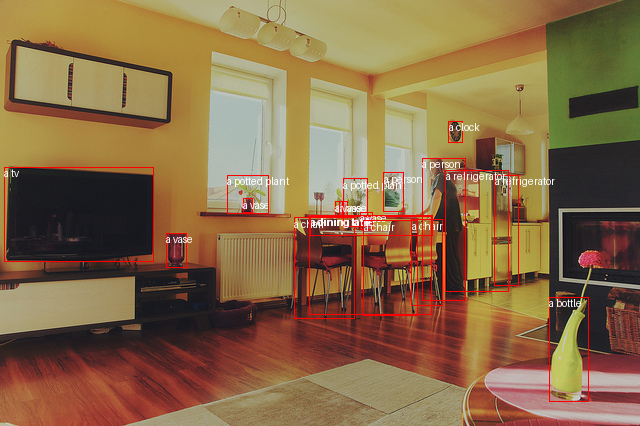

In [5]:
visualize(val_outputs, 0)

In [ ]:
len(labels)

In [ ]:
'19 19 19' in concepts